# 06. Monte Carlo Sampling

With __Monte Carlo sampling__, also referred to as __parametric bootstrap__, the probabiliy distribution of model parameters is approximated by generating a large number of artificial measurements (resampling) and re-estimating model parameters for each. 

In [1]:
import sys 
sys.path.append(r'..')

from estim8.models import FmuModel
from estim8 import visualization, datatypes, Estimator
from estim8.error_models import LinearErrorModel
import pandas as pd

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 6.1 Load the model 

In [2]:
SimpleBatchModel = FmuModel(path='SimpleBatch.fmu')

## 6.2 Import experimental data & create an `Experiment` object
To quantify the extend at which uncertainty in experimental data propagates to parameter estimates, we need to define it first using a mathematical model. Per default, `estim8` assumes anormally distributed measurement noise, e.g. in the `LinearErrorModel` (see Notebook 3.). 

In [3]:
data = datatypes.Experiment(pd.read_excel(r'SimpleBatch_Data.xlsx', index_col=0), error_model=LinearErrorModel(slope=0.05, offset=0.01))

## 6.3 Defining the estimation problem

In [4]:
## define unknown parameters with upper and lower bounds
bounds = {
    'X0': [0.05, 0.15],
    'mu_max': [0.1, 0.9],
    'Y_XS': [0.1, 1]
}

In [5]:
estimator = Estimator(
    model=SimpleBatchModel,
    bounds=bounds,
    data=data,
    t=[0, 10, 0.1],
    metric='negLL'
)

## 6.4 Start Monte Carlo Sampling

_Note_: This method puts considerable amount of work on your machine

In [6]:
mc_samples = estimator.mc_sampling(
    method='de',        
    max_iter=1000,      # maximum iterations for each estimation run 
    n_jobs=1,           # parallelization of each estimation run 
    mcs_at_once=6,      # number of Monte Carlo estimations to run in parallel
    n_samples=100       # number of monte carlo samples
)

---- Sample 1 completed
---- Sample 2 completed
---- Sample 3 completed
---- Sample 4 completed
---- Sample 5 completed
---- Sample 6 completed
---- Sample 7 completed
---- Sample 8 completed
---- Sample 9 completed
---- Sample 10 completed
---- Sample 11 completed
---- Sample 12 completed
---- Sample 13 completed
---- Sample 14 completed
---- Sample 15 completed
---- Sample 16 completed
---- Sample 17 completed
---- Sample 18 completed
---- Sample 19 completed
---- Sample 20 completed
---- Sample 21 completed
---- Sample 22 completed
---- Sample 23 completed
---- Sample 24 completed
---- Sample 25 completed
---- Sample 26 completed
---- Sample 27 completed
---- Sample 28 completed
---- Sample 29 completed
---- Sample 30 completed
---- Sample 31 completed
---- Sample 32 completed
---- Sample 33 completed
---- Sample 34 completed
---- Sample 35 completed
---- Sample 36 completed
---- Sample 37 completed
---- Sample 38 completed
---- Sample 39 completed
---- Sample 40 completed
---- Samp

## 6.5 Evaluation of Monte Carlo Sampling

In [7]:
samples = pd.DataFrame(data = [elem[0] for elem in mc_samples]) # extract the parameter - estimate dictionary frome ach sample and create a  pandas DataFrame

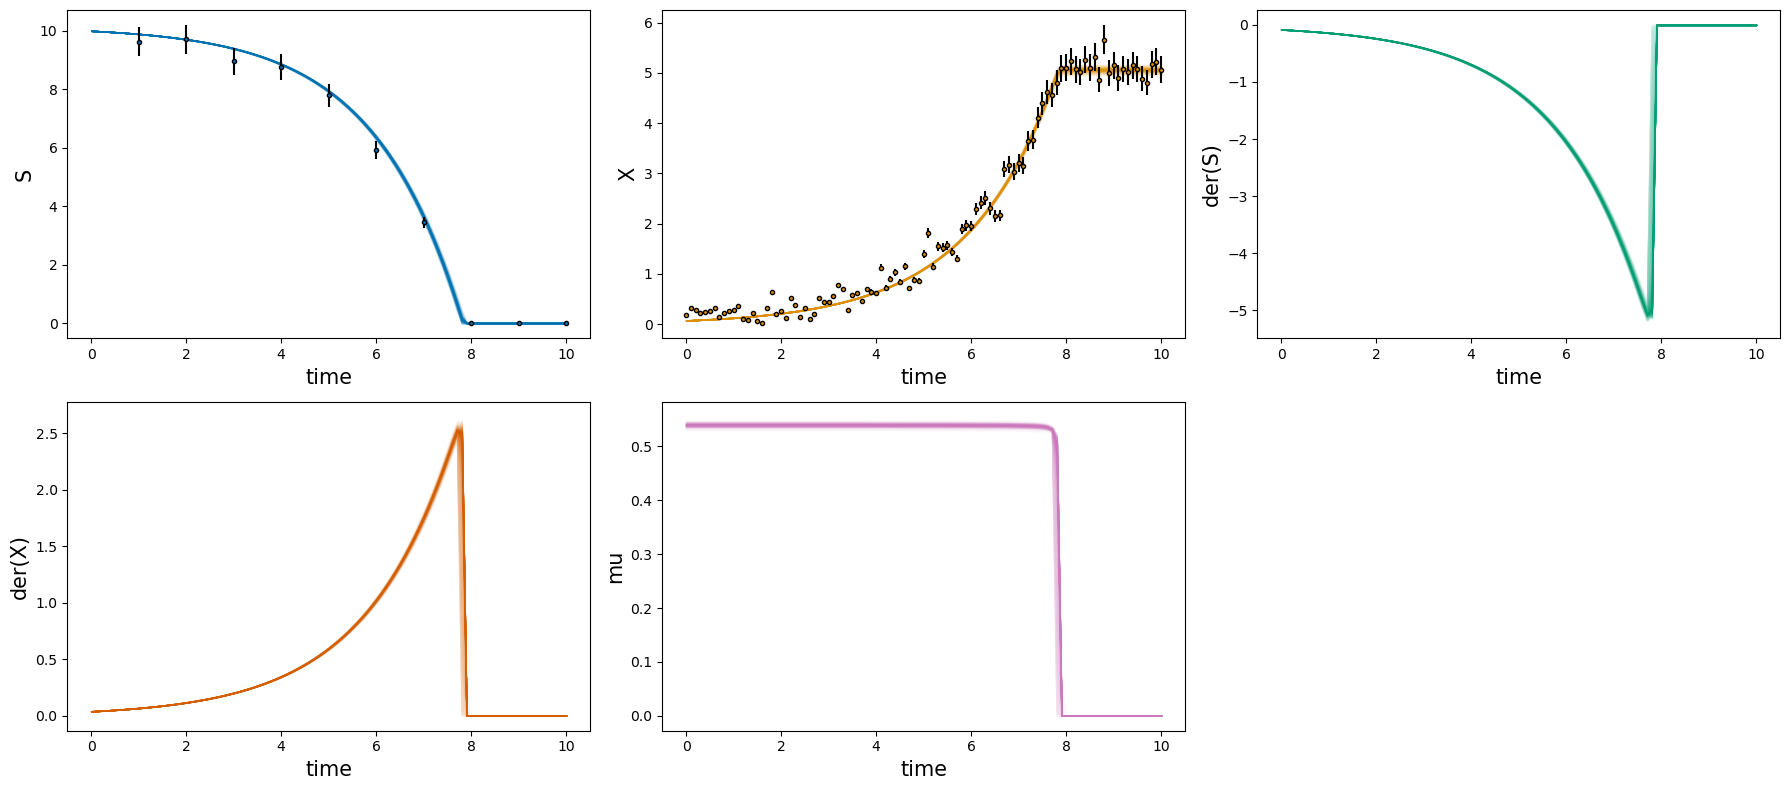

In [8]:
# forward simulations
_ = visualization.plot_estimates_many(mc_samples=samples, estimator=estimator)

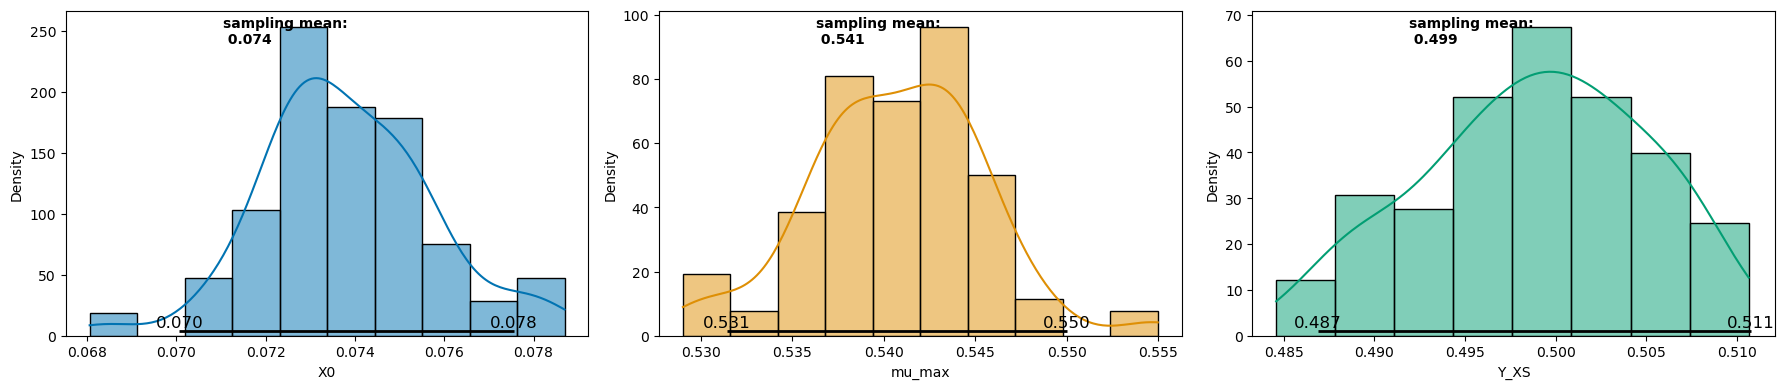

In [9]:
_ = visualization.plot_distributions(samples)

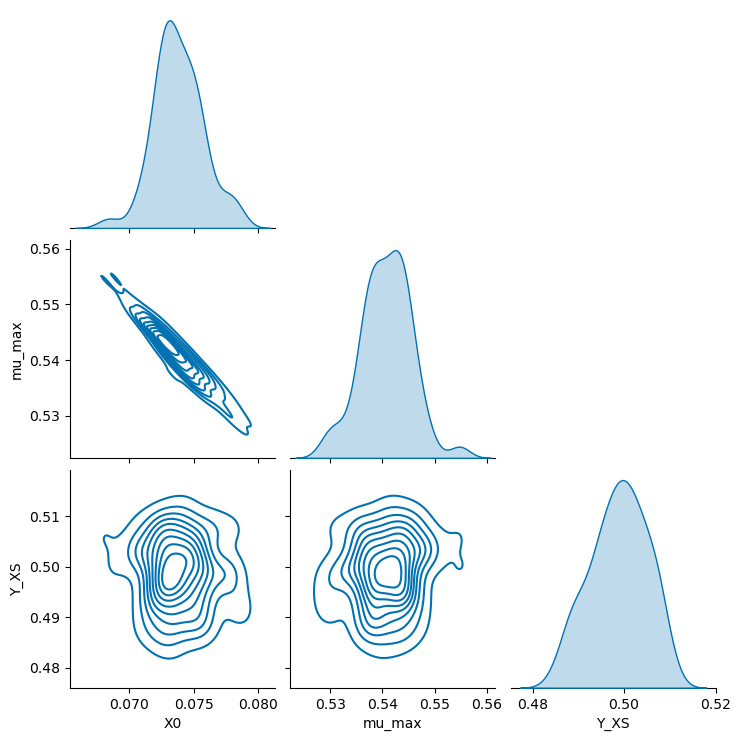

In [10]:
_ = visualization.plot_pairs(samples)

## 6.6 Custom distributions

Since there are many possible distributions to describe such an error, we did not provide a selection, but instead enable the use of any scipy.stats.rv_continuous distribution. For more information, please check out the section '3.2.3 Custom error models' in Notebook 3.

